# Structured Variational Message Passing for Estimation

In this demo we compare mean-field VMP with structured VMP. We consider a continuous state-space model similar to the one defined in the first and second demo. Initially, we assumed the state evolution noise observed. In the present demo, we are interested in estimating the hidden state in conjunction with the state evolution precision. We assume the observation variance known.

\begin{align*}
    s_t &\sim \mathcal{N}(s_{t-1}, w^{-1})\\
    x_t &\sim \mathcal{N}(s_t, v)
\end{align*}

The SSM can be represented by the following Forney-style factor graph, where the pictured section is chained over time:

```
                 (w)
                  |
    (s_t_min) -->[N]-->[=]--> (s_t)
                        |    
                 (v)-->[N]
                        |
                      (y_t)
```

We generate some data and build the generative model

In [9]:
n_samples = 100
v_data = 1.0
w_data = 10.0
s_0_data = 0.0

s_data = Vector{Float64}(n_samples)
x_data = Vector{Float64}(n_samples)
s_t_min_data = s_0_data
for t = 1:n_samples
    s_data[t] = s_t_min_data + sqrt(1/w_data)*randn() # Evolution model
    x_data[t] = s_data[t] + sqrt(v_data)*randn() # Observation model
    
    s_t_min_data = s_data[t]
end
;

# Build

In [10]:
using ForneyLab

g = FactorGraph()

@RV w ~ Gamma(constant(0.01), constant(0.01), id=:w)
@RV s_0 ~ GaussianMeanVariance(constant(0.0), constant(100.0), id=:s_0)

s = Vector{Variable}(n_samples)
x = Vector{Variable}(n_samples)
s_t_min = s_0
for t = 1:n_samples
    @RV s[t] ~ GaussianMeanPrecision(s_t_min, w, id=:s_*t)
    @RV x[t] ~ GaussianMeanVariance(s[t], constant(v_data), id=:x_*t)
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t)
end
;

# Schedule Mean-Field

First we schedule the mean-field algorithm, which fully factorizes the recognition distribution

\begin{align*}
    q(w, s_0, \dots, s_T) = q(w)\prod_{t=0}^T q(s_t)
\end{align*}

In [11]:
q_mf = RecognitionFactorization()

# Define recognition factorization
q_w_mf = RecognitionFactor(w)
q_s_mf = Vector{RecognitionFactor}(n_samples)
q_s_0_mf = RecognitionFactor(s_0)
for t=1:n_samples
    q_s_mf[t] = RecognitionFactor(s[t])
end

# Compile algorithm
algo_q_w_mf = variationalAlgorithm(q_w_mf, name="WMF")
algo_q_s_mf = variationalAlgorithm([q_s_0_mf; q_s_mf], name="SMF")
algo_F_mf = freeEnergyAlgorithm(name="MF")
;

# Schedule Structured

We compare the mean-field algorithm with a structured algorithm that retains the state-dependencies in the recognition factorization

\begin{align*}
    q(w, s_0, \dots, s_T) = q(w)\times q(s_0, \dots, s_T)
\end{align*}

In [12]:
rf_struct = RecognitionFactorization()

# Define the recognition factorization
q_w_struct = RecognitionFactor(w)
q_s_struct = RecognitionFactor([s_0; s])

# Compile algorithm
algo_q_w_struct = variationalAlgorithm(q_w_struct, name="WStruct")
algo_q_s_struct = variationalAlgorithm(q_s_struct, name="SStruct")
algo_F_struct = freeEnergyAlgorithm(name="Struct")
;

# Infer Mean-Field

In [13]:
# Load algorithm
eval(parse(algo_q_w_mf))
eval(parse(algo_q_s_mf))
eval(parse(algo_F_mf))

# Initialize data
data = Dict(:x => x_data)
n_its = 20

# Initial recognition distributions
marginals_mf = Dict{Symbol, ProbabilityDistribution}(:w => vague(Gamma))
for t = 0:n_samples
    marginals_mf[:s_*t] = vague(Gaussian)
end

# Run algorithm
F_mf = Vector{Float64}(n_its)
for i = 1:n_its
    stepWMF!(data, marginals_mf)
    stepSMF!(data, marginals_mf)
    
    F_mf[i] = freeEnergyMF(data, marginals_mf)
end
;

# Infer Structured

When initializing the marginals for the structured algorithm, we need to take care of joint distributions over adjacent state variables. This illustrates how the structured algorithm retains the covariance over the state chain.

In [14]:
# Load algorithm
eval(parse(algo_q_w_struct))
eval(parse(algo_q_s_struct))
eval(parse(algo_F_struct))

# Initial recognition distributions
marginals_struct = Dict{Symbol, ProbabilityDistribution}(:w => vague(Gamma))
for t = 1:n_samples
    marginals_struct[Symbol("s_$(t)_s_$(t-1)")] = vague(Gaussian, 2)
end

# Run algorithm
F_struct = Vector{Float64}(n_its)
for i = 1:n_its
    stepSStruct!(data, marginals_struct)
    stepWStruct!(data, marginals_struct)

    F_struct[i] = freeEnergyStruct(data, marginals_struct)
end
;

# Results

The results show a smoother fit for the state estimates of the structured algorithm. Inspecting the free energy, the plot for structured algorithm eventually dives below the plot for the mean-field algorithm, proving the smoother fit to be a better explanation for the data.

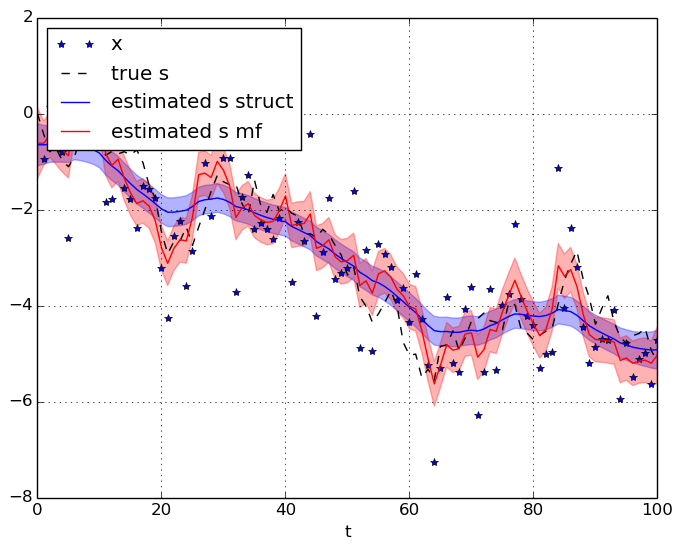

In [15]:
using PyPlot

# Collect state estimates
m_s_mf = [mean(marginals_mf[:s_*t]) for t=0:n_samples]
v_s_mf = [var(marginals_mf[:s_*t]) for t=0:n_samples]
m_s_struct = [mean(marginals_struct[:s_*t]) for t=0:n_samples]
v_s_struct = [var(marginals_struct[:s_*t]) for t=0:n_samples]

# Plot estimated state
plot(collect(1:n_samples), x_data, "b*", label="x")
plot(collect(0:n_samples), [0.0; s_data], "k--", label="true s")
plot(collect(0:n_samples), m_s_struct, "b-", label="estimated s struct")
fill_between(collect(0:n_samples), m_s_struct-sqrt.(v_s_struct), m_s_struct+sqrt.(v_s_struct), color="b", alpha=0.3);
plot(collect(0:n_samples), m_s_mf, "r-", label="estimated s mf")
fill_between(collect(0:n_samples), m_s_mf-sqrt.(v_s_mf), m_s_mf+sqrt.(v_s_mf), color="r", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");

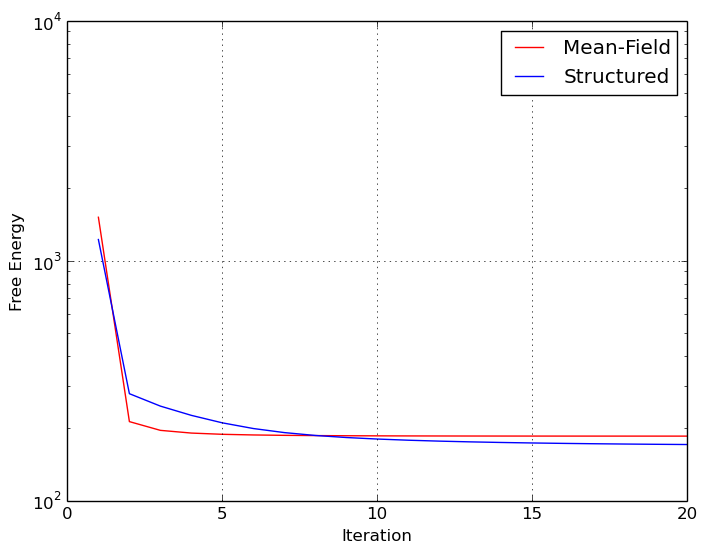

PyObject <matplotlib.text.Text object at 0x7f8869a173d0>

In [16]:
plot(1:n_its, F_mf, color="red", label="Mean-Field")
plot(1:n_its, F_struct, color="blue", label="Structured")
grid("on")
legend()
yscale("log")
xlabel("Iteration")
ylabel("Free Energy")